# Bike sharing demand

https://www.kaggle.com/competitions/bike-sharing-demand

날짜별로 매 시간대에 count를 예측, 평가는 RMSE로 해야 함.

In [46]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)

## 1) EDA

### 데이터 로드 및 데이터 살펴보기

- train 및 test 데이터 로드 및 기본 데이터 확인
- 데이터 속성
  * datetime - hourly date + timestamp  
  * season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
  * holiday - whether the day is considered a holiday
  * workingday - whether the day is neither a weekend nor holiday
  * weather
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
  * temp - temperature in Celsius
  * atemp - "feels like" temperature in Celsius (체감온도)
  * humidity - relative humidity (습도)
  * windspeed - wind speed
  * casual - number of non-registered user rentals initiated
  * registered - number of registered user rentals initiated
  * count - number of total rentals

In [48]:
file_path = os.path.join(os.path.abspath("."), *['data'])

file_path

'/Users/jmac/project/kaggle/bike_sharing_demand/data'

In [542]:
train_pdf = pd.read_csv(os.path.join(file_path, 'train.csv'))

train_pdf.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [543]:
test_pdf = pd.read_csv(os.path.join(file_path, 'test.csv'))
test_pdf.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


train과 test 데이터 간의 column 차이가 있음을 확인함.
- test에 없는 casual과 registered 데이터가 있음.
- 따라서 train 데이터 재정비가 필요.

In [51]:
(set(train_pdf.columns)-{'count'}) - set(test_pdf.columns)

{'casual', 'registered'}

In [544]:
re_cols = set(train_pdf.columns) - ((set(train_pdf.columns)-{'count'}) - set(test_pdf.columns))

In [545]:
train_pdf2 = train_pdf[list(re_cols)].copy()

In [546]:
train_pdf2.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity
10881,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50
10882,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57
10883,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61
10884,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61
10885,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66


null 값 확인 -> 없음

In [26]:
train_pdf2.isnull().sum()

windspeed     0
datetime      0
atemp         0
season        0
humidity      0
temp          0
weather       0
workingday    0
holiday       0
count         0
dtype: int64

In [27]:
test_pdf.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

데이터 타입 확인
- datetime 부분을 형변환 시켜주기

In [29]:
train_pdf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   windspeed   10886 non-null  float64
 1   datetime    10886 non-null  object 
 2   atemp       10886 non-null  float64
 3   season      10886 non-null  int64  
 4   humidity    10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   weather     10886 non-null  int64  
 7   workingday  10886 non-null  int64  
 8   holiday     10886 non-null  int64  
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


In [547]:
train_pdf2['datetime'] = pd.to_datetime(train_pdf2['datetime'])
train_pdf2['year'] = train_pdf2.datetime.dt.year
train_pdf2['month'] = train_pdf2.datetime.dt.month
train_pdf2['day'] = train_pdf2.datetime.dt.day
train_pdf2['hour'] = train_pdf2.datetime.dt.hour

train_pdf2.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity,year,month,day,hour
10881,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50,2012,12,19,19
10882,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57,2012,12,19,20
10883,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61,2012,12,19,21
10884,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61,2012,12,19,22
10885,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66,2012,12,19,23


### 그래프로 데이터 확인

#### 시간에 따른 대여량 확인
- year: 2011보다 2012년도에 대여량임 많음
- month: 여름에 대여량이 더 많음
- day : 별 차이가 없음
- hour: 출퇴근 시간대에 차이가 남

<AxesSubplot:xlabel='hour', ylabel='count'>

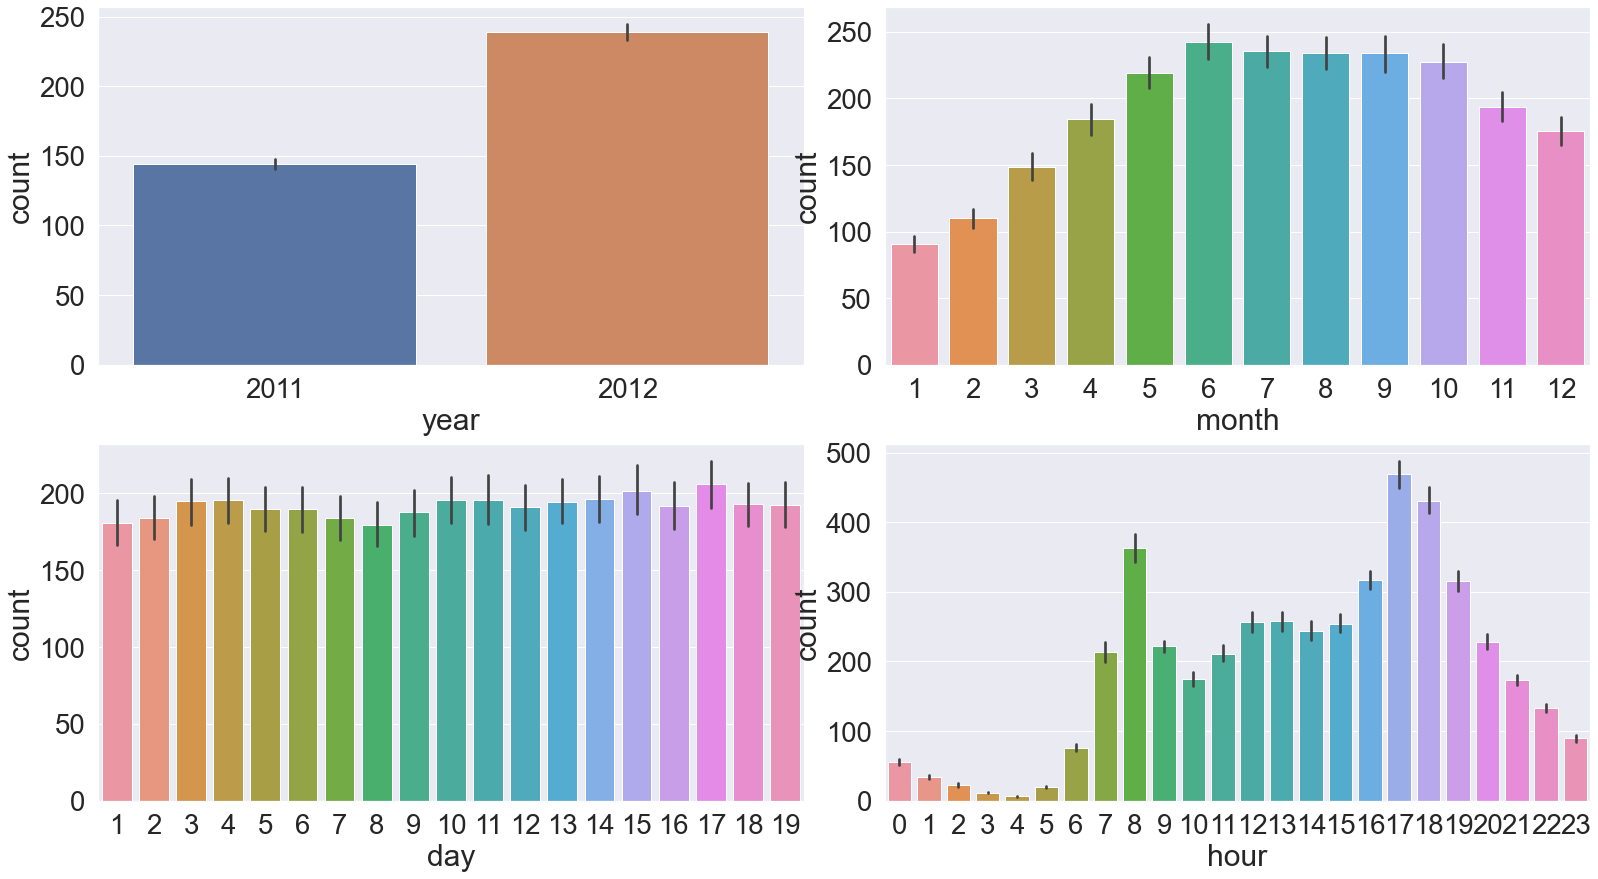

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,12))
fig.tight_layout(h_pad=3)

sns.barplot(data=train_pdf2, x='year', y='count', ax=ax[0][0])
sns.barplot(data=train_pdf2, x='month', y='count', ax=ax[0][1])
sns.barplot(data=train_pdf2, x='day', y='count', ax=ax[1][0])
sns.barplot(data=train_pdf2, x='hour', y='count', ax=ax[1][1])


#### 시간에 따른 대여량 평균 분포 확인

<AxesSubplot:xlabel='hour', ylabel='count'>

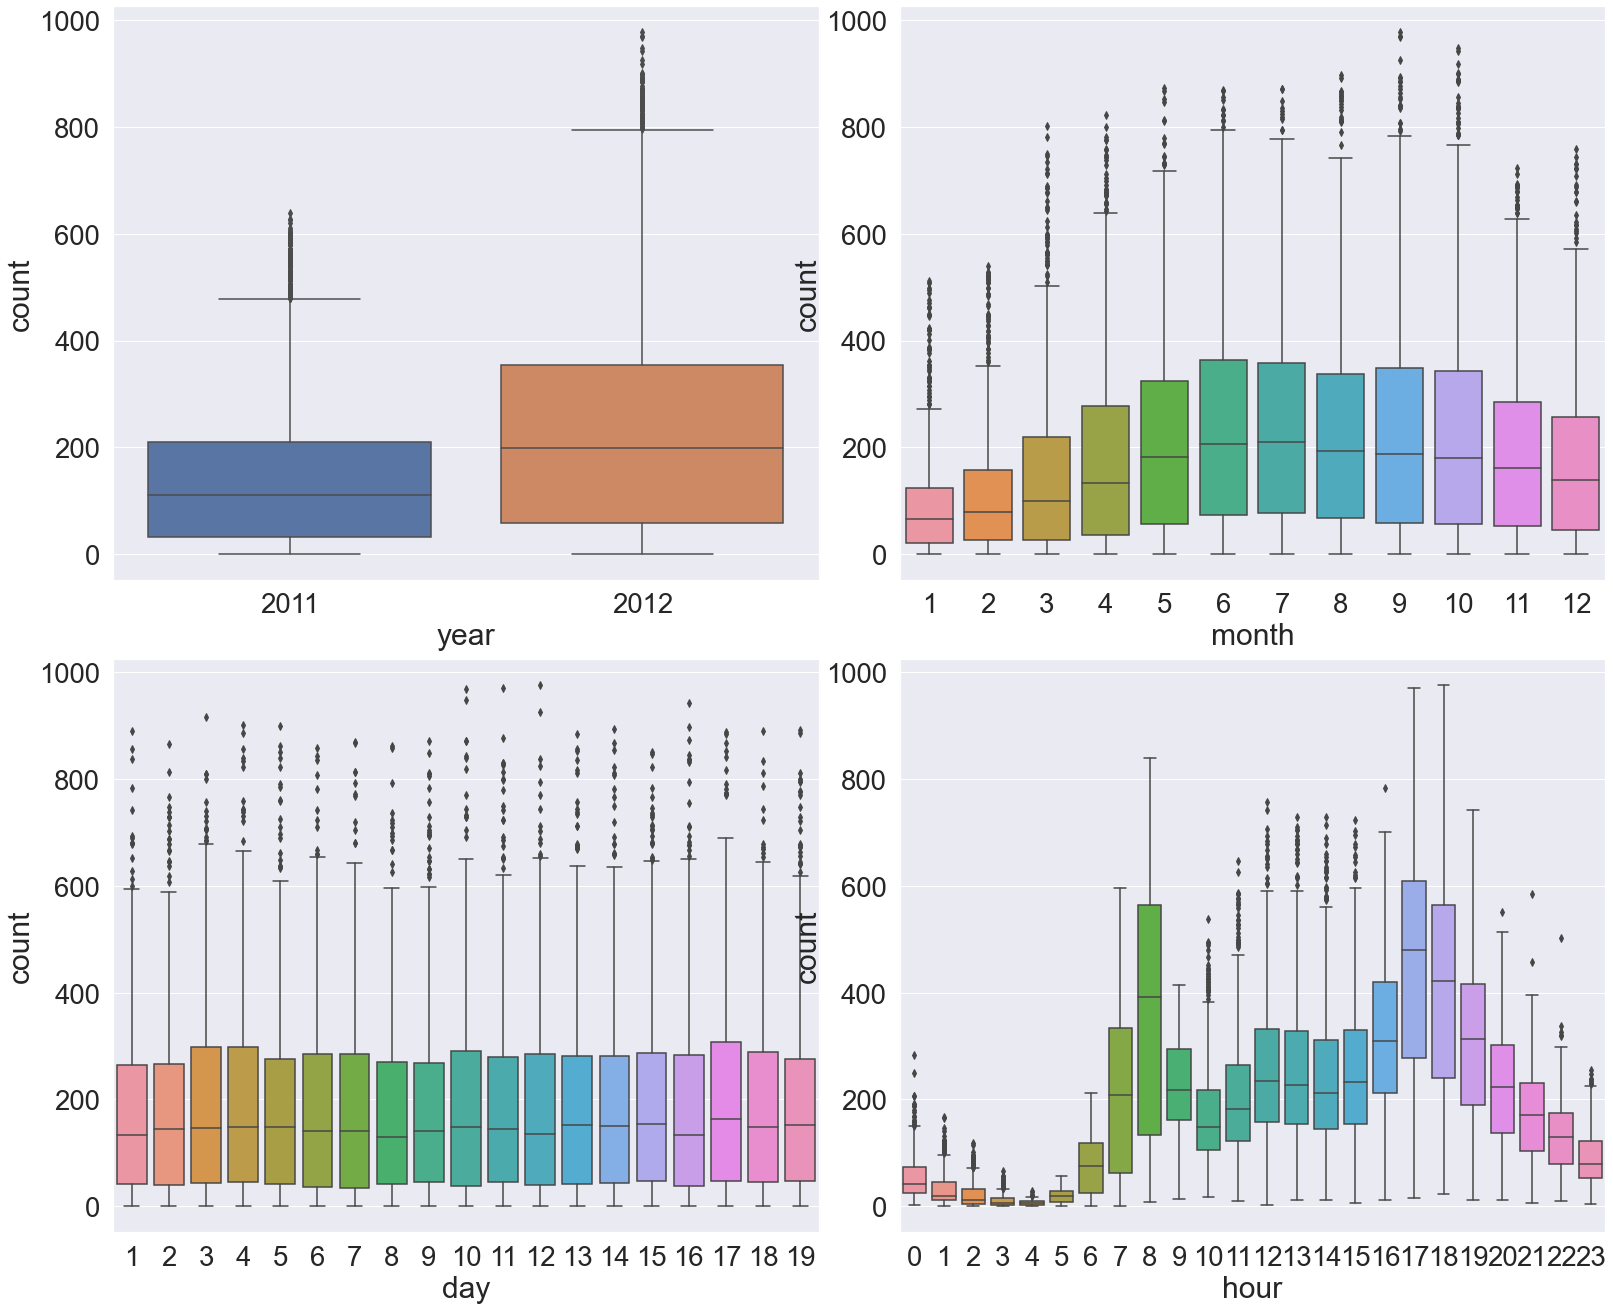

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,18))
fig.tight_layout(h_pad=3)

sns.boxplot(data=train_pdf2, x='year', y='count', ax=ax[0][0])
sns.boxplot(data=train_pdf2, x='month', y='count', ax=ax[0][1])
sns.boxplot(data=train_pdf2, x='day', y='count', ax=ax[1][0])
sns.boxplot(data=train_pdf2, x='hour', y='count', ax=ax[1][1])

#### 시간에 따른 그 외 데이터 확인
- season: 4(winter)에는 상대적으로 조금 덜 이용하는 경향이 있음
- weather: 4(Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)에는 날씨가 안좋아서 이용을 거의 안함
- holiday: 0(non-holiday)에는 workingday와 동일한 패턴이 나옴
- workingday: 1(workingday)는 holiday(0, non-holiday) 와 동일한 데이터 패턴이 나옴.

즉, weather가 아주 심한날 제외하고는 일정하게 시간대별로 출/퇴근 시간대에 많이 사용하며, 이것은 workingday만 유효함. (휴일은 둥글게 분포됨)

<AxesSubplot:xlabel='hour', ylabel='count'>

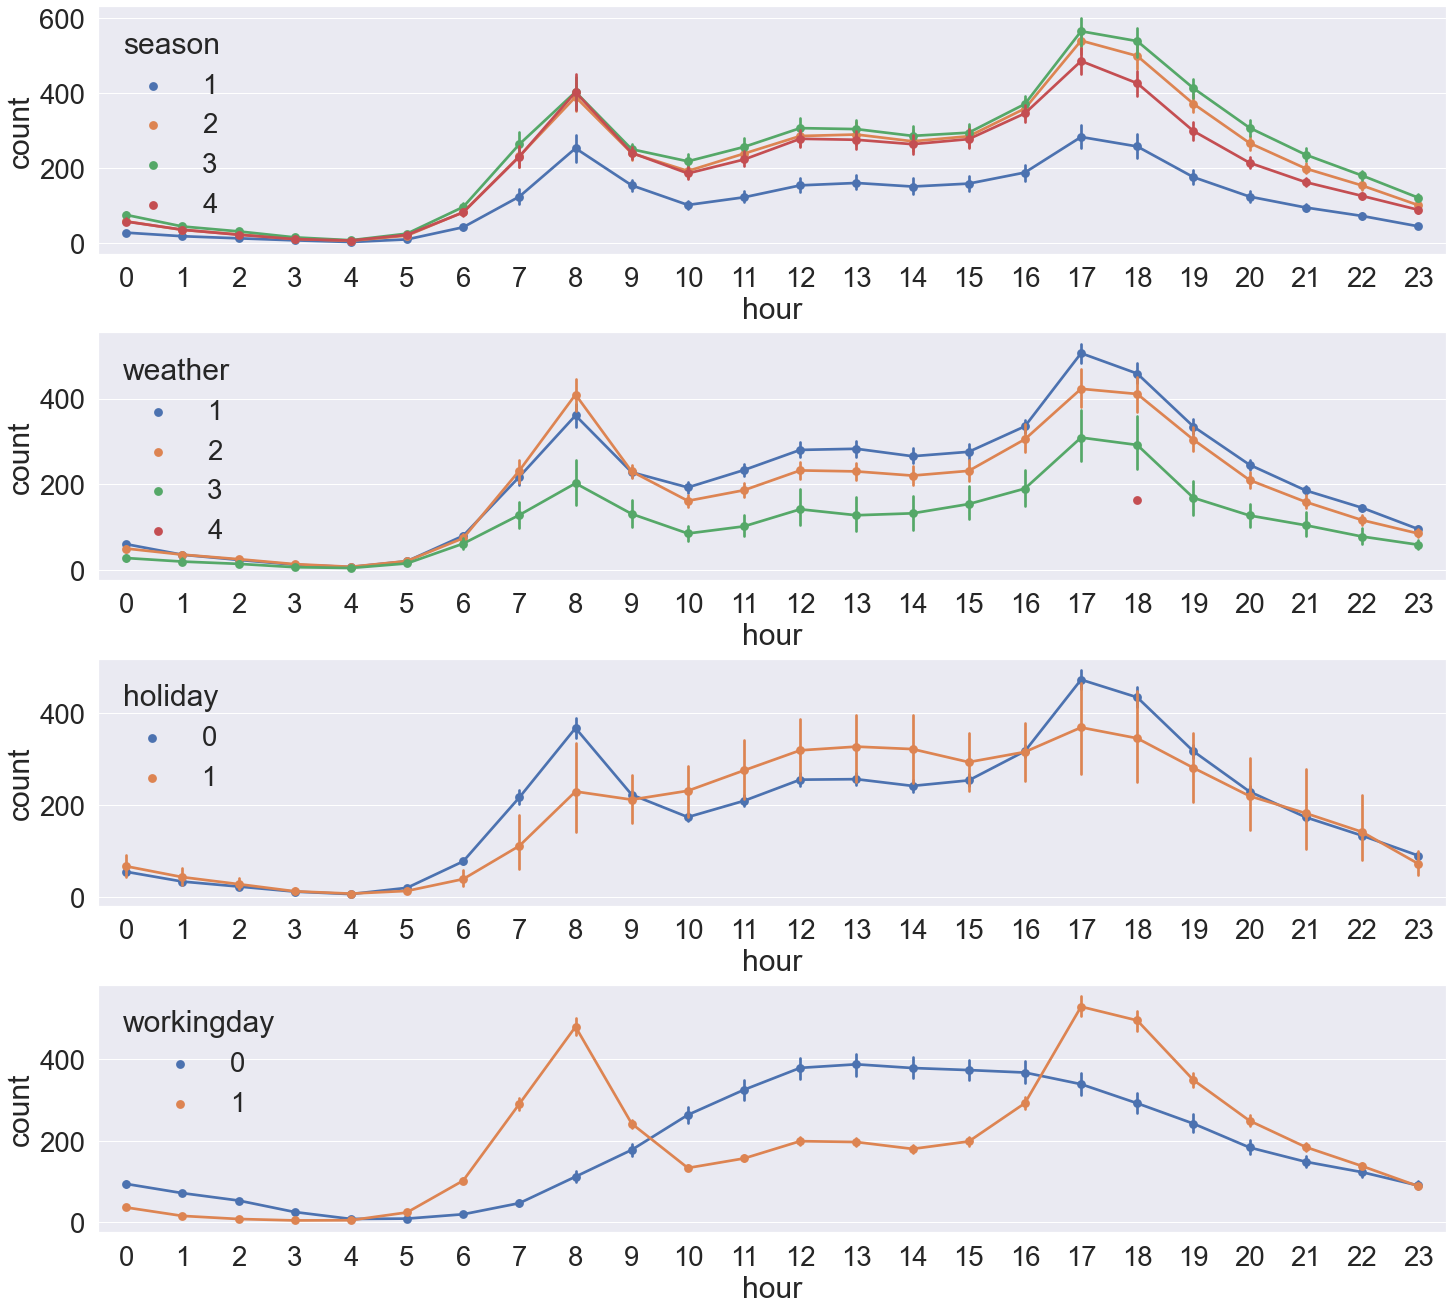

In [50]:
fig, ax = plt.subplots(nrows=4,figsize=(20,18))
fig.tight_layout(h_pad=3)

sns.pointplot(data=train_pdf2, x='hour', y='count', hue='season', ax=ax[0])
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='weather', ax=ax[1])
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='holiday', ax=ax[2])
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='workingday', ax=ax[3])

참고로, 요일별로도 한번 확인해볼까?

- 5,6은 토/일을 의미하므로 workingday와 다르게 holiday의 특성을 띄고 있음

In [548]:
train_pdf2['day_of_week'] = train_pdf2['datetime'].dt.day_of_week
train_pdf2.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity,year,month,day,hour,day_of_week
10881,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50,2012,12,19,19,2
10882,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57,2012,12,19,20,2
10883,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61,2012,12,19,21,2
10884,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61,2012,12,19,22,2
10885,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66,2012,12,19,23,2


<AxesSubplot:xlabel='hour', ylabel='count'>

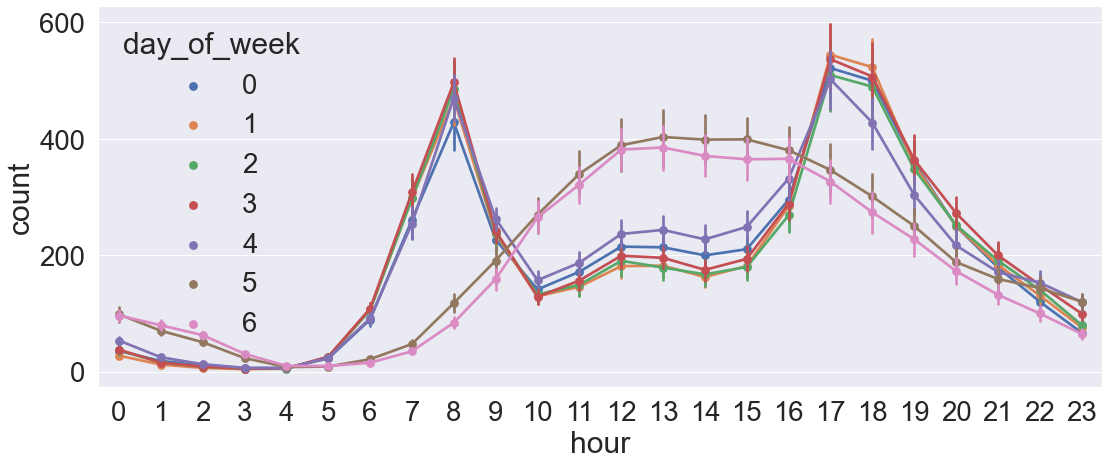

In [62]:
fig, ax = plt.subplots(figsize=(18,7))
# print(ax)
sns.pointplot(data=train_pdf2, x='hour', y='count', hue='day_of_week', ax=ax)

#### Numeric 데이터 확인
- temp: 일정함
- atemp: 일정함
- humidity: min-25%간에 차이가 있음
- windspeed: 75%-max간의 차이가 있음

값을 보면 temp와 atemp는 비슷한 경향이 있고,
windspeed가 바람인데 0으로 찍힌 데이터가 많음. 아마 오류 값일듯?

In [41]:
train_pdf2[['temp', 'atemp', 'humidity', 'windspeed']].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


<AxesSubplot:xlabel='windspeed', ylabel='count'>

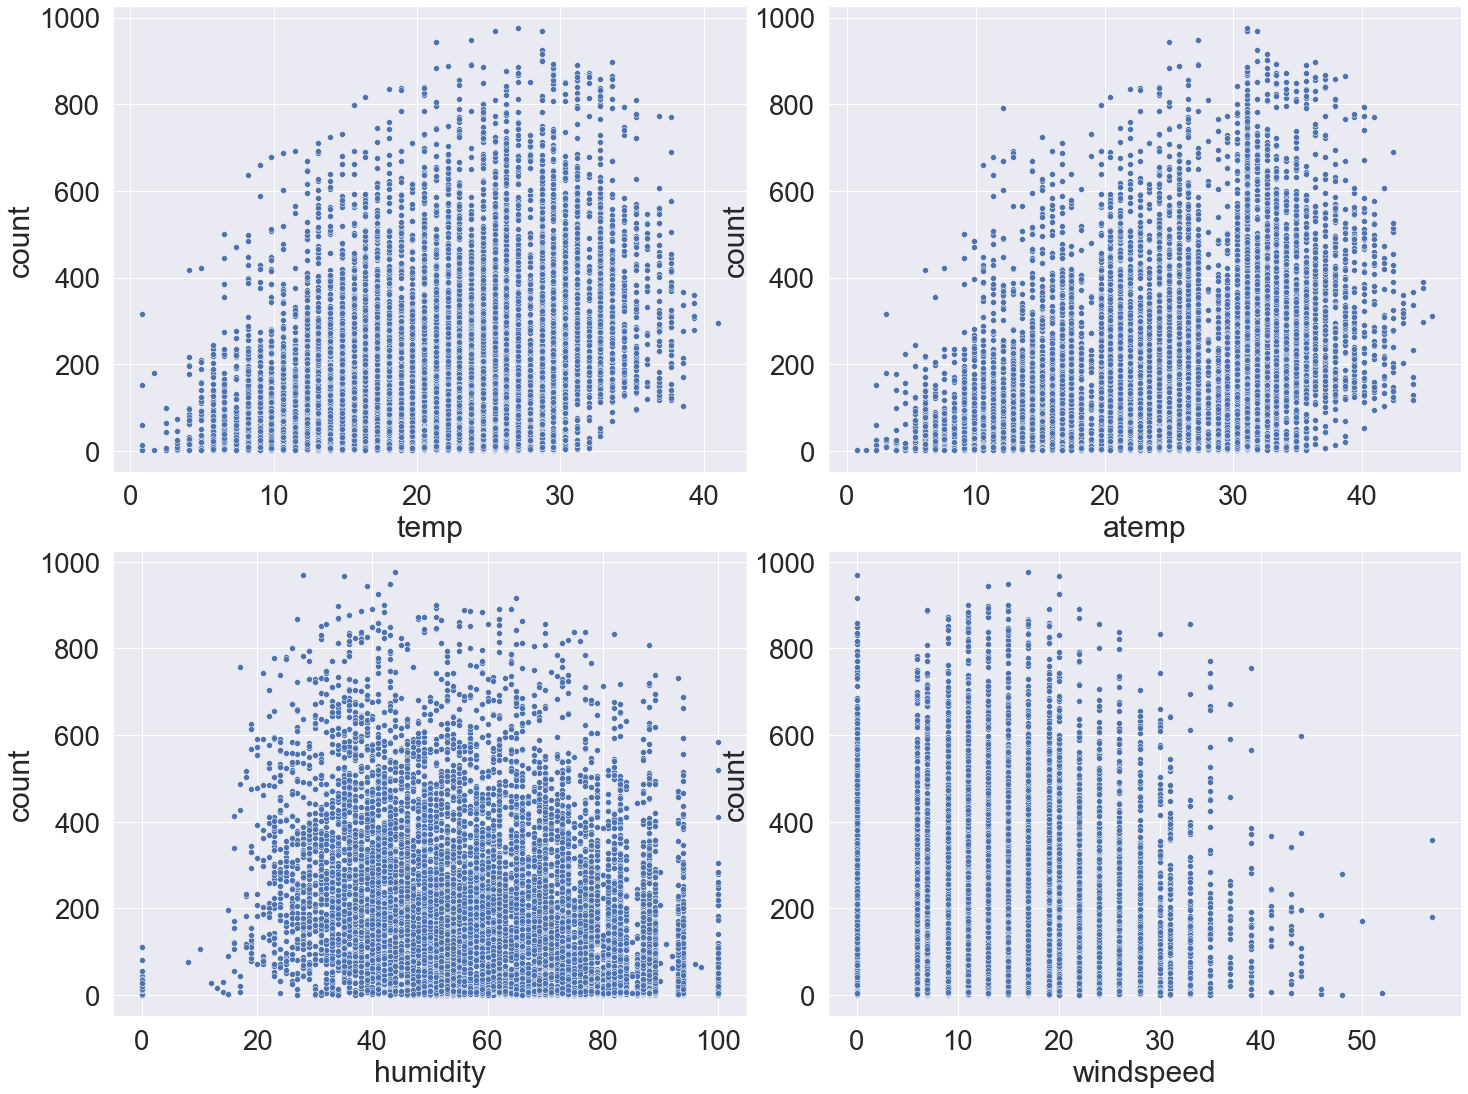

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

fig.tight_layout(h_pad=3)

sns.scatterplot(data=train_pdf2, x='temp', y='count', ax=ax[0][0])
sns.scatterplot(data=train_pdf2, x='atemp', y='count', ax=ax[0][1])
sns.scatterplot(data=train_pdf2, x='humidity', y='count', ax=ax[1][0])
sns.scatterplot(data=train_pdf2, x='windspeed', y='count', ax=ax[1][1])

### 상관관계
- count랑 전체 변수들간의 상관 관계는 거의 없음
- temp와 atemp와 상관관계는 너무 높음
- 나머지 humidity와 windspeed도 너무 상관관계가 없음

In [40]:
train_pdf2[['count', 'temp', 'atemp', 'humidity', 'windspeed', 'holiday', 'season', 'weather']].corr()

,count,temp,atemp,humidity,windspeed,holiday,season,weather
count,1.000000,0.394454,0.389784,-0.317371,0.101369,-0.005393,0.163439,-0.128655
temp,0.394454,1.000000,0.984948,-0.064949,-0.017852,0.000295,0.258689,-0.055035
atemp,0.389784,0.984948,1.000000,-0.043536,-0.057473,-0.005215,0.264744,-0.055376
humidity,-0.317371,-0.064949,-0.043536,1.000000,-0.318607,0.001929,0.190610,0.406244
windspeed,0.101369,-0.017852,-0.057473,-0.318607,1.000000,0.008409,-0.147121,0.007261
holiday,-0.005393,0.000295,-0.005215,0.001929,0.008409,1.000000,0.029368,-0.007074
season,0.163439,0.258689,0.264744,0.190610,-0.147121,0.029368,1.000000,0.008879
weather,-0.128655,-0.055035,-0.055376,0.406244,0.007261,-0.007074,0.008879,1.000000


<AxesSubplot:>

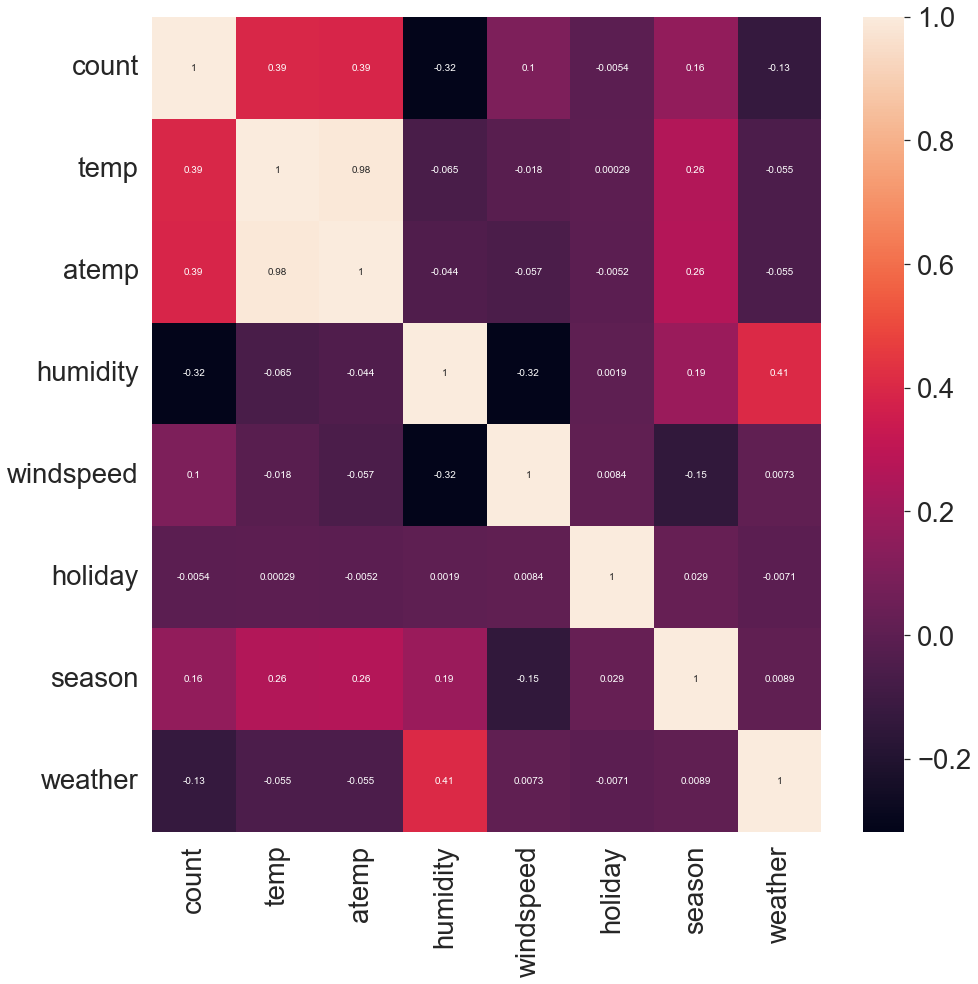

In [44]:
plt.figure(figsize=(15,15))
sns.heatmap(train_pdf2[['count', 'temp', 'atemp', 'humidity', 'windspeed', 'holiday', 'season', 'weather']].corr(), annot=True)

### 다중공선성 확인

- temp랑 atemp가 아무래도 다중공선성을 띌 수도 있으니깐 이를 확인하는 법
- statsmodels.stats.outliners_influence import variance_inflation_factor를 통해서 확인할 수 있음
- 보면  'atemp', 'temp'가 값이 200이 넘어감. 'humidity'도 값이 10이 넘어감. 보통 10 이상의 점수를 받으면 feature가 다른 feature들과 굉장히 상관관계가 높음

In [81]:
import statsmodels.stats.outliers_influence
dir(statsmodels.stats.outliers_influence)

['Appender',
 'GLMInfluence',
 'MLEInfluence',
 'OLS',
 'OLSInfluence',
 '_BaseInfluenceMixin',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_plot_influence_doc',
 'cache_readonly',
 'defaultdict',
 'lzip',
 'maybe_unwrap_results',
 'multipletests',
 'np',
 'outlier_test',
 'reset_ramsey',
 'summary_table',
 'variance_inflation_factor']

In [82]:
train_pdf2.shape

(10886, 15)

In [84]:
# 각 columns마다 전체 row 데이터가 나옴
train_pdf2.values[:2]

array([[0.0, Timestamp('2011-01-01 00:00:00'), 14.395, 1, 81, 9.84, 1, 0,
        0, 16, 2011, 1, 1, 0, 5],
       [0.0, Timestamp('2011-01-01 01:00:00'), 13.635, 1, 80, 9.02, 1, 0,
        0, 40, 2011, 1, 1, 1, 5]], dtype=object)

atemp와 temp는 다중공선성 관계에 있음을 알 수 있다. (특히 위 그래프에서 확인)

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

tmp_train_pdf = train_pdf2[['weather', 'atemp', 'season', 'temp', 'windspeed','holiday', 'humidity', 'count' ]].copy()
vif = pd.DataFrame()

vif['vif factor'] = [ variance_inflation_factor(tmp_train_pdf.values, i) for i in range(tmp_train_pdf.shape[1])]
vif['features'] = tmp_train_pdf.columns

vif

,vif factor,features
0,7.286031,weather
1,290.420236,atemp
2,6.803422,season
3,263.839433,temp
4,2.984343,windspeed
5,1.030878,holiday
6,12.228869,humidity
7,2.800236,count


### 목적변수 확인

보면 0쪽에 데이터가 많이 몰려 있음 -> 정규분포를 띄지 않으니, outliers를 제거해줘야 할것 같으며, 그럼에도 정규분포를 안띄면 log취해야 함

#### 목적변수에 대한 왜도(Skewness)와 첨도(kurtosis)를 확인
- 왜도(Skewness, 비대칭도)
  - 분포가 얼마나 비대칭을 띄는가 알려주는 척도
  - skew의 수치가 -2~+2 정도가 되어야 치우침이 없는 데이터
  - -2 이하는 왼쪽으로 쏠린 데이터 (negative) -> 변환 방법 : square, cube root, <b>log2</b>
  - +2 이상은 오른쪽으로 쏠린 데이터(positive) -> square root, cube, <b>log10</b>
- 첨도(Kurtosis)
  - 분포의 뾰족함이나 평평함에 관련된것이 아니라 분포의 tail에 대한 것
  - 한쪽 꼬리 부분의 극값과 다른 꼬리 부분의 극값의 차이를 보여줌
  - 아웃라이어를 찾을 때 주로 사용
  - 첨도가 높다 -> 아웃라이어가 많다.

skew:  1.2420662117180776
kurt:  1.3000929518398334


/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

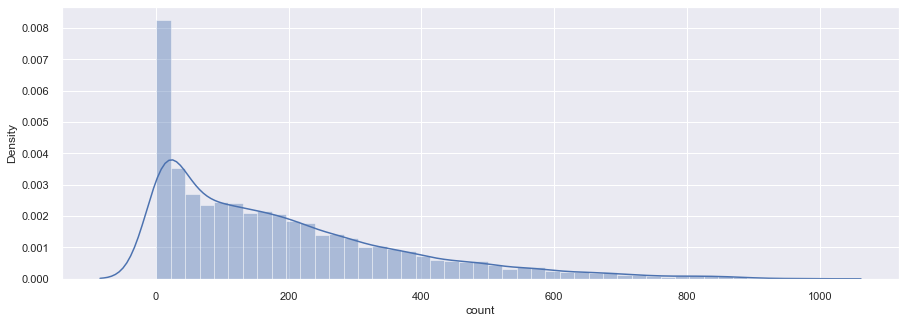

In [97]:
# print(dir(train_pdf2['count']))
print("skew: ", train_pdf2['count'].skew())
print("kurt: ", train_pdf2['count'].kurt())
# sns.set(rc = {'figure.figsize': (30,5)})
plt.figure(figsize=(15,5))
sns.distplot(train_pdf2['count'])

In [16]:
# 보면, 75%-max간에 차이가 커서 오른쪽으로 꼬리가 긴 그래프임을 알 수 있음
train_pdf2[['count']].describe()

,count
count,10886.000000
mean,191.574132
std,181.144454
min,1.000000
25%,42.000000
50%,145.000000
75%,284.000000
max,977.000000


### 이상치 제거

- 방법은 3sigma나 IQR을 통해서 제거 가능

#### 방법 1) 3Sigma

원천에서 mean +- 3*std

In [412]:

count_mean, count_std = train_pdf2['count'].mean(), train_pdf2['count'].std()
print(f"count's mean : {count_mean}, std : {count_std}")
print(f"count's 3sigma {count_mean-3*count_std} ~ {count_mean+3*count_std}")

print(f"before {train_pdf2.shape}")
final_train_pdf = train_pdf2[train_pdf2['count']<count_mean+3*count_std].copy()
print(f"after {final_train_pdf.shape} -> removed {train_pdf2.shape[0]-final_train_pdf.shape[0]} outliers")

count's mean : 191.57413191254824, std : 181.14445383028527
count's 3sigma -351.8592295783075 ~ 735.0074934034039
before (10886, 15)
after (10739, 15) -> removed 147 outliers


In [413]:
final_train_pdf.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity,year,month,day,hour,day_of_week
10881,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50,2012,12,19,19,2
10882,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57,2012,12,19,20,2
10883,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61,2012,12,19,21,2
10884,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61,2012,12,19,22,2
10885,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66,2012,12,19,23,2


count에 대한 이상치를 제거한 뒤, 데이터를 확인했으나, 데이터가 치우쳐있음을 확인하고 log취함 -> 어느정도 정규분포를 따름을 확인



/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jmac/project/kaggle/bike_sharing_demand/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.40968461015429, 4.523106928071492, 0.9537631807794262))

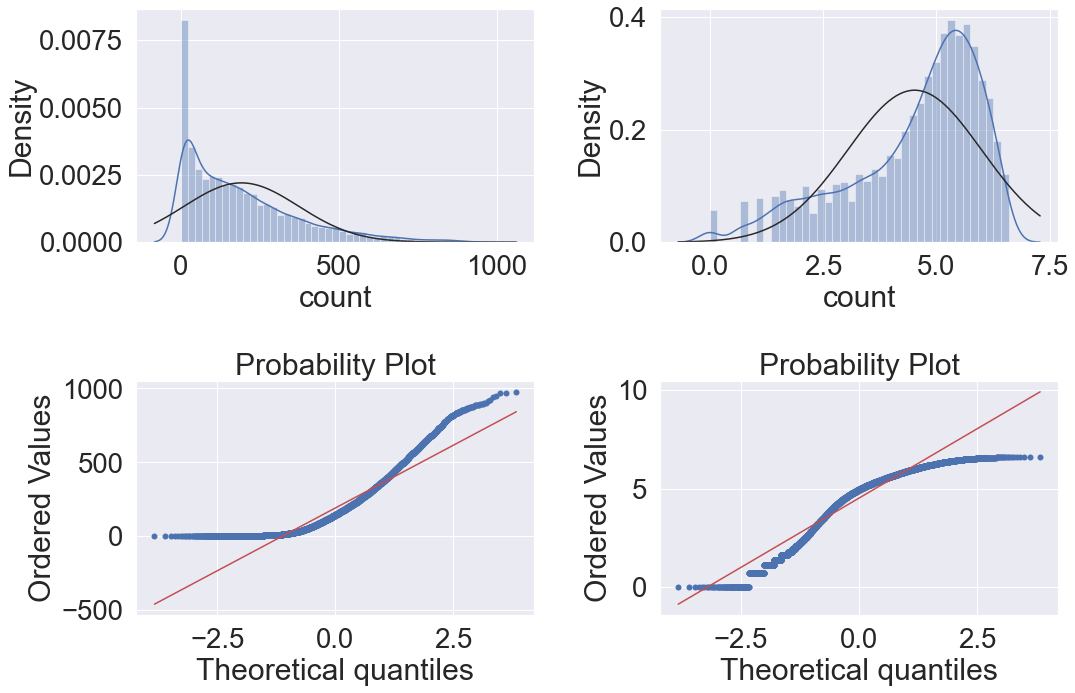

In [174]:
from scipy import stats
from scipy.stats import norm 

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.tight_layout(h_pad=3)
sns.distplot(train_pdf2['count'], fit=norm, ax=ax[0][0])
sns.distplot(np.log(final_train_pdf['count']), fit=norm, ax=ax[0][1])
stats.probplot(train_pdf2['count'], plot=ax[1][0])
stats.probplot(np.log(final_train_pdf['count']), plot=ax[1][1])

#### 방법 2) IQR

- Q1 : 25%
- Q3 : 75%
- IQR = Q3-Q1
- outliers
    * minimum : q1 - 1.5*iqr
    * maximum : q3 + 1.5*iqr

In [175]:
q1 = train_pdf2['count'].quantile(0.25)
q3 = train_pdf2['count'].quantile(0.75)
iqr = q3-q1
iqr_step = 1.5*iqr

print(f"outliears.... count < {q1-iqr_step} (q1-(1.5*iqr))  | count > {q3+iqr_step} (q3+(1.5*iqr)) ")
outlier_index = train_pdf2[(train_pdf2['count']<q1-iqr_step) | (train_pdf2['count']>q3+iqr_step)].index
print(f"outlier index length: {len(outlier_index)}")

train_pdf2.loc[outlier_index].tail()

final_train_pdf3 = train_pdf2.copy()
final_train_pdf3.drop(outlier_index, axis=0, inplace=True)
final_train_pdf3.tail()
print(f"{train_pdf2.shape} -> {final_train_pdf3.shape} (remove rows {train_pdf2.shape[0]-final_train_pdf3.shape[0]})")

outliears.... count < -321.0 (q1-(1.5*iqr))  | count > 647.0 (q3+(1.5*iqr)) 
outlier index length: 300
(10886, 15) -> (10586, 15) (remove rows 300)


#### 사용할 feature에 대한 이상치 제거하기

In [414]:
train_pdf2.columns

Index(['windspeed', 'workingday', 'temp', 'count', 'weather', 'atemp',
       'holiday', 'datetime', 'season', 'humidity', 'year', 'month', 'day',
       'hour', 'day_of_week'],
      dtype='object')

In [549]:
from collections import Counter
def detetct_iqr_outliers(df, n, features):
    outlier_indexs = []
    for col in features:
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3-q1
        iqr_step = 1.5*iqr

        col_outlier_index = df[ (df[col] < q1-iqr_step) | (df[col]>q3+iqr_step)].index
        print(f"{col} -> {q1-iqr_step} ~ {q3-iqr_step} -> outliers {len(col_outlier_index)}")
        outlier_indexs.extend(col_outlier_index)
    
    outlier_indices = Counter(outlier_indexs)
    # print(outlier_indices)
    # Counter({6611: 1, 6634: 1, 6635: 1, 6649: 1, 6658: 1 ...
    multiple_outliers = list(k for k, v in outlier_indices.items() if v >= n)
    print("="*100)
    print(f"detect multiple outliers(condition >={2}) : {len(multiple_outliers)}")
    return multiple_outliers

drop_outliers = detetct_iqr_outliers(train_pdf2, 2, ['windspeed', 'temp', 'count', 'atemp', 'humidity'])
final_train_pdf = train_pdf2.drop(drop_outliers, axis=0).reset_index(drop=True)
print(f"final_train_pdf: {train_pdf2.shape} -> {final_train_pdf.shape} (removed outliers: {train_pdf2.shape[0] - final_train_pdf.shape[0]})")

windspeed -> -7.993100000000002 ~ 2.0032999999999994 -> outliers 227
temp -> -4.51 ~ 7.789999999999999 -> outliers 0
count -> -321.0 ~ -79.0 -> outliers 300
atemp -> -4.927500000000002 ~ 9.467499999999998 -> outliers 0
humidity -> 2.0 ~ 32.0 -> outliers 22
detect multiple outliers(condition >=2) : 11
final_train_pdf: (10886, 15) -> (10875, 15) (removed outliers: 11)


## 2) 전처리
현재 train 데이터에 대해서 outlier는 multiple outlier로 2개 이상으로 반복 outlier일때 제거하게끔 했음 (final_train_pdf 생성)
1. 목적 변수인 count가 정규분포를 띄지 않아서 log를 취해야 함. (아직, train_pdf2에 적용 안함)
2. windspeed가 0 데이터 처리 필요
3. categorical 변수에 one-hot encoding 적용 필요

### 1. 목적 변수에 대한 log적용

In [118]:
final_train_pdf.tail()

,windspeed,workingday,temp,count,weather,atemp,holiday,datetime,season,humidity,year,month,day,hour,day_of_week
10870,26.0027,1,15.58,336,1,19.695,0,2012-12-19 19:00:00,4,50,2012,12,19,19,2
10871,15.0013,1,14.76,241,1,17.425,0,2012-12-19 20:00:00,4,57,2012,12,19,20,2
10872,15.0013,1,13.94,168,1,15.910,0,2012-12-19 21:00:00,4,61,2012,12,19,21,2
10873,6.0032,1,13.94,129,1,17.425,0,2012-12-19 22:00:00,4,61,2012,12,19,22,2
10874,8.9981,1,13.12,88,1,16.665,0,2012-12-19 23:00:00,4,66,2012,12,19,23,2


In [550]:
final_train_pdf['log_count'] = np.log(final_train_pdf['count'])
final_train_pdf.drop(columns=['count'], inplace=True)
final_train_pdf.tail() 


,windspeed,workingday,temp,weather,atemp,holiday,datetime,season,humidity,year,month,day,hour,day_of_week,log_count
10870,26.0027,1,15.58,1,19.695,0,2012-12-19 19:00:00,4,50,2012,12,19,19,2,5.817111
10871,15.0013,1,14.76,1,17.425,0,2012-12-19 20:00:00,4,57,2012,12,19,20,2,5.484797
10872,15.0013,1,13.94,1,15.910,0,2012-12-19 21:00:00,4,61,2012,12,19,21,2,5.123964
10873,6.0032,1,13.94,1,17.425,0,2012-12-19 22:00:00,4,61,2012,12,19,22,2,4.859812
10874,8.9981,1,13.12,1,16.665,0,2012-12-19 23:00:00,4,66,2012,12,19,23,2,4.477337


### 2. windspeed에 대한 처리

In [551]:
windspeed_0 = final_train_pdf[final_train_pdf['windspeed']==0].shape[0]
print(f"전체 데이터 프레임에서 {round(windspeed_0/final_train_pdf.shape[0],2)}% (windspeed가 0인 데이터 {windspeed_0} 개)")

전체 데이터 프레임에서 0.12% (windspeed가 0인 데이터 1313 개)


In [156]:
final_train_pdf['windspeed'].describe()

count    10875.000000
mean        12.776388
std          8.136305
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

In [552]:
print(final_train_pdf['windspeed'].median())
windspeed_mead = final_train_pdf['windspeed'].median()
final_train_pdf['windspeed'] = final_train_pdf['windspeed'].apply(lambda x: windspeed_mead if x==0 else x )

12.998


In [553]:
final_train_pdf[final_train_pdf['windspeed']==0].shape[0]

0

### 3. categorical 변수에 대한 one-hot encoding

#### 3.1 우선 의미 없는 변수 제거

- datetime -> year, month, day, hour, day_of_week으로 풀어서 사용했기 때문에 해당 datetime 제거
- temp와 atemp간에 다중공선성이 존재하기 때문에 변수 한개만 사용
- workingday와 holiday도 같은 의미이기 때문에 한개 제거

In [554]:
final_train_pdf.drop(columns=['datetime', 'atemp', 'workingday'], inplace=True)
final_train_pdf.tail()

,windspeed,temp,weather,holiday,season,humidity,year,month,day,hour,day_of_week,log_count
10870,26.0027,15.58,1,0,4,50,2012,12,19,19,2,5.817111
10871,15.0013,14.76,1,0,4,57,2012,12,19,20,2,5.484797
10872,15.0013,13.94,1,0,4,61,2012,12,19,21,2,5.123964
10873,6.0032,13.94,1,0,4,61,2012,12,19,22,2,4.859812
10874,8.9981,13.12,1,0,4,66,2012,12,19,23,2,4.477337


#### 3.2 categorical 변수에 one-hot encoding 적용

In [183]:
final_train_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   windspeed    10875 non-null  float64
 1   temp         10875 non-null  float64
 2   weather      10875 non-null  int64  
 3   holiday      10875 non-null  int64  
 4   season       10875 non-null  int64  
 5   humidity     10875 non-null  int64  
 6   year         10875 non-null  int64  
 7   month        10875 non-null  int64  
 8   day          10875 non-null  int64  
 9   hour         10875 non-null  int64  
 10  day_of_week  10875 non-null  int64  
 11  log_count    10875 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 1019.7 KB


위 변수들을 확인해 보면 dtype이 int64로 되어 있기 때문에 데이터를 category로 처럼 인식하기 위해 one-hot encoding 처리 함
- 다만, train 데이터와 test 데이터를 보면, 매달 20%는 test로 분리되어 있기 때문에 day에 대해서는 one-hot encoding 및 feature에서 제외

In [558]:
# print(f"아예 처리할 필요없는 cols(목적변수): ['log_count'], 예외: year, month, day, hour, day_of_week 변수 제거(numeric_cols에 값이 반영됨) ")
print(f"아예 처리할 필요없는 cols(목적변수): ['log_count'] (예외: day 제거)")
dummies_cols = ['weather', 'season', 'holiday', 'year', 'month', 'hour', 'day_of_week']
# dummies_cols = ['weather', 'season', 'holiday']
print(f"dummies_cols : {dummies_cols}")
# numeric_cols = list((set(final_train_pdf.columns) - {'log_count', 'day', 'hour', 'month', 'year', 'day_of_week'}) - set(dummies_cols))
numeric_cols = list((set(final_train_pdf.columns) - {'log_count', 'year', 'month', 'day', 'hour', 'day_of_week'}) - set(dummies_cols))
print(f"numeric_clos: {numeric_cols}")

아예 처리할 필요없는 cols(목적변수): ['log_count'] (예외: day 제거)
dummies_cols : ['weather', 'season', 'holiday', 'year', 'month', 'hour', 'day_of_week']
numeric_clos: ['humidity', 'windspeed', 'temp']


In [572]:
def _do_one_hot_encoding(df, features):
    new_df = df.copy()
    for col in features:
        # print(f"col = {col}")
        # print(df.tail())
        # new_df = pd.get_dummies(new_df, columns=[col], drop_first=True)
        new_df = pd.get_dummies(new_df, columns=[col])
        # print(df.tail())      
    
    return new_df

new_train_df = _do_one_hot_encoding(final_train_pdf, dummies_cols)
print(f"cols : {list(new_train_df.columns)}")
new_train_df.tail()

cols : ['windspeed', 'temp', 'humidity', 'day', 'log_count', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1', 'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


,windspeed,temp,humidity,day,log_count,weather_1,weather_2,weather_3,weather_4,season_1,...,hour_21,hour_22,hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
10870,26.0027,15.58,50,19,5.817111,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10871,15.0013,14.76,57,19,5.484797,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10872,15.0013,13.94,61,19,5.123964,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
10873,6.0032,13.94,61,19,4.859812,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
10874,8.9981,13.12,66,19,4.477337,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### test_pdf도 동일하게 전처리

In [461]:
test_pdf.tail() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [561]:
test_pdf['datetime'] = pd.to_datetime(test_pdf['datetime'])
test_pdf['year'] = test_pdf['datetime'].dt.year
test_pdf['month'] = test_pdf['datetime'].dt.month
# test_pdf['day'] = test_pdf['datetime'].dt.day
test_pdf['hour'] = test_pdf['datetime'].dt.hour
test_pdf['day_of_week'] = test_pdf['datetime'].dt.day_of_week

In [562]:
test_pdf.drop(columns=['datetime', 'atemp', 'workingday'], inplace=True)
# test_pdf.drop(columns=[ 'atemp', 'workingday'], inplace=True)
test_pdf.tail()

,season,holiday,weather,temp,humidity,windspeed,year,month,hour,day_of_week
6488,1,0,2,10.66,60,11.0014,2012,12,19,0
6489,1,0,2,10.66,60,11.0014,2012,12,20,0
6490,1,0,1,10.66,60,11.0014,2012,12,21,0
6491,1,0,1,10.66,56,8.9981,2012,12,22,0
6492,1,0,1,10.66,65,8.9981,2012,12,23,0


In [563]:
dummies_cols

['weather', 'season', 'holiday', 'year', 'month', 'hour', 'day_of_week']

In [573]:
new_test_df = _do_one_hot_encoding(test_pdf, dummies_cols)
print(f"cols : {list(new_test_df.columns)}")


cols : ['temp', 'humidity', 'windspeed', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1', 'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


In [565]:
new_test_df.tail() 

,temp,humidity,windspeed,weather_2,weather_3,weather_4,season_2,season_3,season_4,holiday_1,...,hour_20,hour_21,hour_22,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
6488,10.66,60,11.0014,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6489,10.66,60,11.0014,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6490,10.66,60,11.0014,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6491,10.66,56,8.9981,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6492,10.66,65,8.9981,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 모델링

### train 데이터 나누기
- log_count는 y값으로 따로 제거하고, year, month, day, hour 값은 쓰지 않기 때문에 feature에서 제거함

In [574]:
feature_cols = list(set(new_train_df.columns.tolist()) - {'log_count', 'day'})
feature_cols

['month_11',
 'hour_17',
 'hour_22',
 'month_4',
 'weather_3',
 'month_7',
 'hour_8',
 'day_of_week_4',
 'day_of_week_6',
 'day_of_week_2',
 'season_2',
 'hour_0',
 'hour_11',
 'month_9',
 'humidity',
 'hour_6',
 'hour_14',
 'hour_15',
 'hour_7',
 'hour_23',
 'month_3',
 'windspeed',
 'weather_2',
 'hour_10',
 'hour_3',
 'month_5',
 'hour_13',
 'day_of_week_5',
 'month_1',
 'hour_21',
 'month_12',
 'hour_20',
 'day_of_week_3',
 'hour_1',
 'hour_5',
 'weather_1',
 'hour_16',
 'season_1',
 'year_2012',
 'hour_4',
 'month_6',
 'holiday_0',
 'month_2',
 'month_8',
 'hour_18',
 'day_of_week_1',
 'hour_12',
 'season_4',
 'hour_9',
 'hour_19',
 'weather_4',
 'temp',
 'season_3',
 'year_2011',
 'month_10',
 'holiday_1',
 'day_of_week_0',
 'hour_2']

In [575]:
x_train_pdf = new_train_df[feature_cols]
y_train_pdf = new_train_df['log_count']

print("x_train_pdf")
print(x_train_pdf.tail())
print("="*100)
print("y_train_pdf")
print(y_train_pdf.tail())

x_train_pdf
       month_11  hour_17  hour_22  month_4  weather_3  month_7  hour_8  \
10870         0        0        0        0          0        0       0   
10871         0        0        0        0          0        0       0   
10872         0        0        0        0          0        0       0   
10873         0        0        1        0          0        0       0   
10874         0        0        0        0          0        0       0   

       day_of_week_4  day_of_week_6  day_of_week_2  ...  hour_9  hour_19  \
10870              0              0              1  ...       0        1   
10871              0              0              1  ...       0        0   
10872              0              0              1  ...       0        0   
10873              0              0              1  ...       0        0   
10874              0              0              1  ...       0        0   

       weather_4   temp  season_3  year_2011  month_10  holiday_1  \
10870          0 

In [576]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train_pdf, y_train_pdf, test_size=0.2, random_state=42, shuffle=True)


In [577]:
x_train.shape, y_train.shape

((8700, 58), (8700,))

### 평가
rmsle score

In [317]:
def rmsle_score(pred, real):
    # 예측값과 실제 값을 numpy로 변환
    pred_values = np.array(pred)
    real_values = np.array(real)

    # 예측값과 실제 값에 1을 더하고 로그 변환
    log_predict = np.log(pred_values + 1)
    log_real = np.log(real_values +1)

    # 로그 변환한 예측값에서 로그 변환한 실제 값을 빼고 제곱
    diff = log_predict - log_real
    diff = np.square(diff)

    # 평균
    mean_diff = diff.mean()
    score = np.sqrt(mean_diff)
    return score

In [318]:
from sklearn.metrics._scorer import make_scorer
RMSLE = make_scorer(rmsle_score)

### 1) OLS
단순 선형 회귀 모델

In [264]:
import statsmodels.api as sm 

In [578]:
# ols의 경우, 모델 생성시, y_train, x_train 값을 먼저 넣어서 fit 함
model = sm.OLS(y_train, x_train).fit()
# re = model.fit()

In [579]:
# Prob(F-statistic) 값이 0으로 수렵되고 있어 잘 학습된 모델임을 알 수 있음
# feature 중 P>|t|가 0.5 이상인 값이 없음
# re.summary()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_count   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     870.2
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:11:32   Log-Likelihood:                -8132.8
No. Observations:                8700   AIC:                         1.636e+04
Df Residuals:                    8651   BIC:                         1.671e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
month_11          0.2506      0.021     12.204      0.000       0.210       0.291
hour_17           1.4654      0.033     44.794      0.000       1.401       1.529
hour_22           0.2928      0.032      9.027      0.000       0.229       0.356
month_4           0.0717      0.021      3.403      0.001       0.030       0.113
weather_3         0.1912      0.135      1.417      0.156      -0.073       0.456
month_7           0.1538      0.023      6.703      0.000       0.109       0.199
hour_8            1.2129      0.032     37.393      0.000       1.149       1.276
day_of_week_4     0.4233      0.021     20.141      0.000       0.382       0.465
day_of_week_6     0.3536      0.021     16.565      0.000       0.312       0.395
day_of_week_2     0.2573      0.022     11.932      0.000       0.215       0.300
season_2          0.6438      0.026     24.398      0.000       0.592       0.696
hour_0           -0.6919      0.032    -21.777      0.000      -0.754      -0.630
hour_11           0.6593      0.032     20.375      0.000       0.596       0.723
month_9           0.2844      0.021     13.542      0.000       0.243       0.326
humidity         -0.0027      0.000     -5.586      0.000      -0.004      -0.002
hour_6           -0.4014      0.032    -12.355      0.000      -0.465      -0.338
hour_14           0.7410      0.033     22.209      0.000       0.676       0.806
hour_15           0.8294      0.034     24.570      0.000       0.763       0.896
hour_7            0.5288      0.032     16.292      0.000       0.465       0.592
hour_23          -0.1176      0.032     -3.643      0.000      -0.181      -0.054
month_3           0.1938      0.021      9.128      0.000       0.152       0.235
windspeed        -0.0059      0.001     -5.431      0.000      -0.008      -0.004
weather_2         0.6956      0.134      5.199      0.000       0.433       0.958
hour_10           0.5418      0.032     16.889      0.000       0.479       0.605
hour_3           -2.4243      0.033    -72.557      0.000      -2.490      -2.359
month_5           0.3178      0.021     15.112      0.000       0.277       0.359
hour_13           0.8275      0.033     25.031      0.000       0.763       0.892
day_of_week_5     0.4381      0.021     20.872      0.000       0.397       0.479
month_1          -0.0362      0.022     -1.652      0.099      -0.079       0.007
hour_21           0.5244      0.032     16.454      0.000       0.462       0.587
month_12          0.2163      0.021     10.064      0.000       0.174       0.258
hour_20           0.7981      0.032     24.593      0.000       0.735       0.862
day_of_week_3     0.3308      0.021     15.625      0.000       0.289       0.372
hour_1           -1.3587      0.032    -41.879      0.000      -1.422      -1.295
hour_5           -1.6871      0.033    -51.371   

### 2) RandomForestRegressor
- 앙상블 기법(voting, bagging, boosting, stacking) 중에서 bagging(같은 알고리즘 내에서 다른 sample 조합을 사용)에 속한 알고리즘
- Bagging 방식 사용
  * 동일한 알고리즘으로 여러 분류기를 만들어 보팅으로 최종 결정하는 알고리즘
  * 부트스트래핑(bootstraping=Bootstrap(sample)+Aggregation)으로 여러개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 등의 목적을 위한 샘플링 방식을 의미

- 하이퍼파라메터
  * n_estimators: 결정 트리의 개수를 지정, default 10, 결정트리 개수를 늘릴 수록, 숫자가 늘어날 수록 학습속도가 증가함
  * min_samples_split: 노드를 분할하기 위한 최소한의 데이터 수, 과적합을 제어하는데 사용 (default=2, 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가)
  * min_samples_leaf : 리프노드가 되기 위한 최소한의 샘플 데이터 수, min_samples_split와 과적합 제어 용도, 값이 작을 수록 과적합 가능성 증가, 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요 (default=1)
  * max_features: 무작위로 선택할 feature의 개수
    - 값이 크다면, 랜덤 포레스트의 트리들이 매우 비슷해지고, 가장 두드러진 특성에 맞게 예측함. 값이 작으면 트리들이 서로 매우 달라질 것이고, 오버피팅이 줄어듬. 일반적으로 default값을 사용 (default='auto')
    - 참고로 회귀에서는 max_features=n_features로 전체를 사용하고, 분류에서는 max_features = sqrt(n_features)를 적용
  * max_depth : 트리의 깊이 (default = None, 완벽하게 클래스 값이 결정될때 까지 분할) 또는 데이터 개수가 min_samples_split보다 작아질 때까지 분할, 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요  
  * max_leaf_nodes: 리프노드의 최대 개수 (default: None)

In [307]:
from sklearn.ensemble import RandomForestRegressor

GridSearchCV를 통해서 모델 훈련

In [322]:
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [438]:
import multiprocessing
cpu_count = multiprocessing.cpu_count()
print(f"cpu_count = {cpu_count} -> {round(cpu_count*0.8)}")
cpu_count = round(cpu_count*0.8)

cpu_count = 12 -> 10


In [716]:

# pipeline list 안에 ('name', 변환기) 으로 순서대로 집어넣음
# 예) 
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([ ('scaler', StandardScaler()), ('linear', LinearRegression()))], verbos=True)
# print(pipeline.steps)
# pipeline.fit(x_train, y_train)
# pred = pipeline.predict(x_test)

param_grid = {
    'n_estimators': [1000, 2000],
    # 'max_depth': [None, 5, 10],
    'max_depth': [5, 10],
    'min_samples_split': [4, 8, 10, 16],
    'min_samples_leaf': [4,8,15]
}

# kf = KFold(random_state=42, n_splits=5, shuffle=True)

# scoring을 RMSLE로 맞춰서 최적의 best_parameters를 찾을 수 있음 (참고: n_jobs를 -1로 하면, 병렬로 전체 cpu를 사용)
# rf_gd = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2, scoring=RMSLE)
rf_gd = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=cpu_count), param_grid=param_grid, cv=5, n_jobs=cpu_count, verbose=2, scoring=RMSLE)


In [717]:
rf_gd.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   8.0s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   8.2s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   8.3s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   8.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   8.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  20.0s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  20.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  20.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  20.8s
[CV] END max_depth=5, min_sam

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=10, random_state=42),
             n_jobs=10,
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [4, 8, 15],
                         'min_samples_split': [4, 8, 10, 16],
                         'n_estimators': [1000, 2000]},
             scoring=make_scorer(rmsle_score), verbose=2)

In [718]:
# GridSearchCV를 통해 찾아낸 최적의 params 및 score 확인
print(f"최적의 하이퍼파라미터: {rf_gd.best_params_}")
print(f"최적의 교차 검증 정확도: {rf_gd.best_score_}")
print(f"최적의 교차 테스트 정확도: {rf_gd.score(x_test, y_test)}")

최적의 하이퍼파라미터: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 2000}
최적의 교차 검증 정확도: 0.20523727223591942
최적의 교차 테스트 정확도: 0.2159365695782212


In [749]:
# rf = RandomForestRegressor(random_state=42, n_estimators=2000, min_samples_split=0.1, max_depth=5)
rf = RandomForestRegressor(random_state=42, n_estimators=2000, min_samples_leaf=4, min_samples_split=10, max_depth=5, n_jobs=cpu_count)
# rf = RandomForestRegressor(random_state=42, n_estimators=2000)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=2000, n_jobs=10, random_state=42)

In [750]:
# ensemble 모델의 socre는 Accuracy를 계산하는 함수로 x_test, y_test가 들어간다면, accuracy_score에서는 y_pred, y_test로 평가를 수행함.
rf_train_score = rf.score(x_train, y_train)
rf_test_score = rf.score(x_test, y_test)
print(f"RandomForestRegressor train score: {rf_train_score}")
print(f"RandomForestRegressor test score: {rf_test_score}")

RandomForestRegressor train score: 0.6295857076727722
RandomForestRegressor test score: 0.6064712797876761


In [751]:
# rmsle는 rmse에 로그를 취한 값으로 실측과 예측이 모두 일치하면 0에 수렴함. 
rf_y_pred = rf.predict(x_test)
print(y_test.shape, rf_y_pred.shape )
print(f"RMSLE score: {rmsle_score(rf_y_pred, y_test)}")

(2175,) (2175,)
RMSLE score: 0.2159365695782212


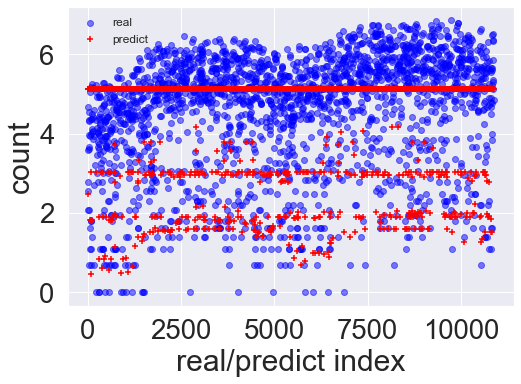

In [752]:
# 참고로 y값은 로그 취했기 때문에 실제 제출할때는 원래 값으로 변환(np.exp) 필요함. (다만, 그래프 그리는 용도면 log 취한 값으로 비교해도 상관없음)
plt.scatter(y_test.index, y_test, alpha=0.5, color='blue', marker='o', label="real")
plt.scatter(y_test.index, rf_y_pred, color='red', marker='+', label="predict")
plt.xlabel("real/predict index")
plt.ylabel("count")
plt.legend(loc='upper left', fontsize=12)

plt.show()

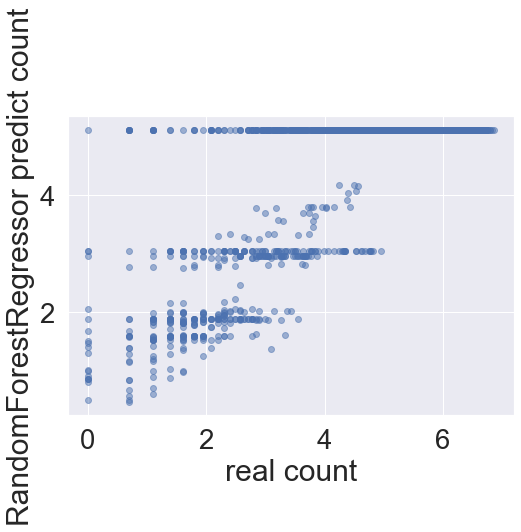

In [753]:
# 참고로 y값은 로그 취했기 때문에 실제 제출할때는 원래 값으로 변환(np.exp) 필요함. (다만, 그래프 그리는 용도면 log 취한 값으로 비교해도 상관없음)
plt.scatter(y_test, rf_y_pred, alpha=0.5)
plt.xlabel("real count")
plt.ylabel("RandomForestRegressor predict count")

plt.show()

RandomForestRegressor에서 취급하는 중요 features 확인

In [754]:
feature_importance = rf.feature_importances_
feature_im_df = pd.Series(feature_importance, index=x_train.columns)
feature_im_df = feature_im_df.sort_values(ascending=False)
feature_im_df


hour_4           0.267877
hour_3           0.214161
hour_2           0.171924
hour_5           0.156999
hour_1           0.122372
day_of_week_6    0.023673
day_of_week_5    0.022855
season_1         0.013172
temp             0.003736
year_2011        0.000540
windspeed        0.000478
month_4          0.000477
year_2012        0.000394
humidity         0.000339
season_2         0.000135
weather_3        0.000117
month_1          0.000112
day_of_week_2    0.000104
month_2          0.000100
month_3          0.000063
season_3         0.000063
weather_2        0.000050
day_of_week_4    0.000045
weather_1        0.000042
day_of_week_3    0.000039
month_5          0.000035
season_4         0.000022
day_of_week_1    0.000019
month_12         0.000018
holiday_1        0.000012
month_10         0.000010
day_of_week_0    0.000005
month_11         0.000003
holiday_0        0.000003
month_6          0.000002
month_8          0.000002
month_7          0.000001
month_9          0.000001
hour_20     

In [755]:
feature_im_df.index

Index(['hour_4', 'hour_3', 'hour_2', 'hour_5', 'hour_1', 'day_of_week_6',
       'day_of_week_5', 'season_1', 'temp', 'year_2011', 'windspeed',
       'month_4', 'year_2012', 'humidity', 'season_2', 'weather_3', 'month_1',
       'day_of_week_2', 'month_2', 'month_3', 'season_3', 'weather_2',
       'day_of_week_4', 'weather_1', 'day_of_week_3', 'month_5', 'season_4',
       'day_of_week_1', 'month_12', 'holiday_1', 'month_10', 'day_of_week_0',
       'month_11', 'holiday_0', 'month_6', 'month_8', 'month_7', 'month_9',
       'hour_20', 'hour_6', 'hour_22', 'hour_8', 'hour_0', 'hour_11',
       'weather_4', 'hour_19', 'hour_9', 'hour_14', 'hour_12', 'hour_17',
       'hour_18', 'hour_15', 'hour_7', 'hour_23', 'hour_10', 'hour_16',
       'hour_13', 'hour_21'],
      dtype='object')

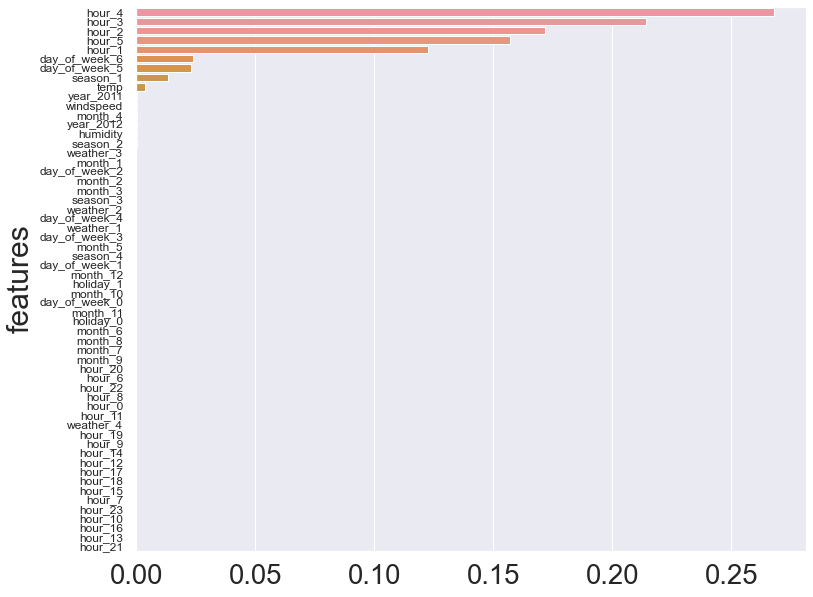

In [756]:
plt.figure(figsize=(12,10))
# plt.ylabel('features', fontsize=10)
plt.ylabel('features')
plt.yticks(fontsize=12)
sns.barplot(x=feature_im_df, y=feature_im_df.index)
plt.show()

#### 기본 값으로 모델 훈련

In [757]:
# rf = RandomForestRegressor(random_state=42, n_estimators=2000, min_samples_split=0.1, max_depth=5)
rf_default = RandomForestRegressor(random_state=42, n_estimators=2000, max_features=len(x_train.columns), n_jobs=cpu_count)
# rf = RandomForestRegressor(random_state=42, n_estimators=2000)
rf_default.fit(x_train, y_train)
# ensemble 모델의 socre는 Accuracy를 계산하는 함수로 x_test, y_test가 들어간다면, accuracy_score에서는 y_pred, y_test로 평가를 수행함.
rf_default_train_score = rf_default.score(x_train, y_train)
rf_default_test_score = rf_default.score(x_test, y_test)
print(f"RandomForestRegressor train score: {rf_default_train_score}")
print(f"RandomForestRegressor test score: {rf_default_test_score}")
rf_default_y_pred = rf_default.predict(x_test)
print(y_test.shape, rf_default_y_pred.shape )
print(f"RMSLE score: {rmsle_score(rf_default_y_pred, y_test)}")

RandomForestRegressor train score: 0.9912315107651207
RandomForestRegressor test score: 0.9313696027164583
(2175,) (2175,)
RMSLE score: 0.12295615430838075


In [758]:
rf_default.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 58,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': 10,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

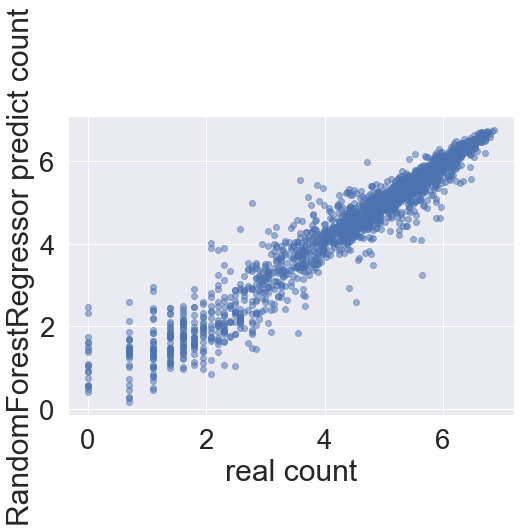

In [759]:
# 참고로 y값은 로그 취했기 때문에 실제 제출할때는 원래 값으로 변환(np.exp) 필요함. (다만, 그래프 그리는 용도면 log 취한 값으로 비교해도 상관없음)
plt.scatter(y_test, rf_default_y_pred, alpha=0.5)
plt.xlabel("real count")
plt.ylabel("RandomForestRegressor predict count")

plt.show()

### 3) GradientBoostingRegressor
- 앙상블 기법(voting, bagging, boosting, stacking) 중에서 boosting(이전 오차를 보완하면서 가중치 부여)에 속한 알고리즘
- 다른 트리 모델들과 달리 가중치에 대한 업데이트를 경사하강법을 이용해서 학습을 진행(learning rate)
- GBM은 예측 성능은 높지만, Greedy Algorithm으로 과적합이 빠르게 되고, 시간이 오래 걸린다는 단점이 있음

하이퍼파라미터
- max_depth : 트리의 최대 깊이, 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요(default=3)
- min_samples_split: 노드를 분할하기 위한 최소한의 샘플 데이터 수, 과적합을 제어하는데 사용, 작게 설정할 수록 분할 노드가 많아져서 과적합 가능성 증가(default=2)
- min_samples_leaf: 리프노드가 되기 위해 필요한 최소한의 샘플 데이터 수, min_samples_split와 함께 과적합 제어 용도, 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요(default=1)
- max_features: 최적 분할을 위해 고려할 feature 개수, (default='none' 모든 feature 사용)
- max_leaf_nodes: 리프 노드의 최대 개수 (default=None 제한 없음)

Boosting에 관한 하이퍼파라미터
- loss: 경사하강법에서 사용할 cost function 지정 (특별한 이유가 없으면 default값인 deviance 적용)
- n_estimators: 생성할 트리 개수를 지정 (default=100)
- learning_rate: 학습을 진행할때마다 적용되는 학습률 (0-1, default=0.1)
- subsample: 개별 트리가 학습에 사용하는 데이터 샘플링 비율(0-1)

In [207]:
from sklearn.ensemble import GradientBoostingRegressor

#### GridSearchCV를 통한 최적의 파라미터 확인

In [684]:
param_grid = {
    'n_estimators' : [2000],
    'learning_rate' : [0.05, 0.01, 0.1],
    'max_depth' : [4, 8],    
    'min_samples_split': [4, 8, 10],
    'min_samples_leaf': [4,8,15] 
}

# GridSearchCV에서 refit=True로 지정하면 best_estimator_에 최적 성능을 보여주는 파라미터가 저장됨
gs_gbr = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=cpu_count, verbose=2, scoring=RMSLE, refit=True)


In [685]:
gs_gbr.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  31.1s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  31.1s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  31.3s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  31.3s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  31.3s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  31.3s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=2000; total time=  31.4s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=8, n_estima

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=10,
             param_grid={'learning_rate': [0.05, 0.01, 0.1],
                         'max_depth': [4, 8], 'min_samples_leaf': [4, 8, 15],
                         'min_samples_split': [4, 8, 10],
                         'n_estimators': [2000]},
             scoring=make_scorer(rmsle_score), verbose=2)

GridSearchCV를 통해서 나온 결과 물
- best_params_ : 최적의 parameters가 나옴 
- bset_scores_ : 최적의 parameters를 ㅌ오해서 나온 최적의 score를 의미함
- cv_results_ : 각 params에 따른 결과를 보여줌 (이때, rank_test_score가 1인 params가 최적의 parameters 임)

In [686]:
gs_gbr.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_samples_leaf': 15,
 'min_samples_split': 4,
 'n_estimators': 2000}

In [668]:
gs_gbr.best_score_

0.2687679964325986

In [669]:
scores_df = pd.DataFrame(gs_gbr.cv_results_)
scores_df[['params','mean_test_score', 'rank_test_score', 'split0_test_score','split1_test_score', 'split2_test_score']].sort_values(by=['rank_test_score']).head()


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
6,"{'learning_rate': 0.001, 'max_depth': 4, 'min_...",0.268768,1,0.269917,0.280239,0.253576
14,"{'learning_rate': 0.001, 'max_depth': 4, 'min_...",0.268759,2,0.269874,0.280187,0.253574
4,"{'learning_rate': 0.001, 'max_depth': 4, 'min_...",0.268750,3,0.269898,0.280198,0.253553
0,"{'learning_rate': 0.001, 'max_depth': 4, 'min_...",0.268748,4,0.269897,0.280198,0.253553
2,"{'learning_rate': 0.001, 'max_depth': 4, 'min_...",0.268748,4,0.269897,0.280198,0.253553


In [672]:

y_pred = gs_gbr.best_estimator_.predict(x_test)
# gs_gbr.score(y_test, y_pred)
print(y_test.shape, y_pred.shape)
print(rmsle_score(y_pred, y_test))

(2175,) (2175,)
0.2722004125634165


#### 모델 재생성 및 평가

GridSearchCV통해 확인한 최적의 parameters로 다시 모델 생성
- 아니면, GridSearchCV에서 refit=True로 하면, gridsearch 그 자체를 사용해도 됨.

In [760]:

gb_regressor = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                         max_depth=4, min_samples_leaf=15, min_samples_split=4,
                                         random_state=42)

gb_regressor.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_leaf=15,
                          min_samples_split=4, n_estimators=1000,
                          random_state=42)

In [761]:
gb_y_pred = gb_regressor.predict(x_test)

In [762]:
# ensemble 모델의 socre는 Accuracy를 계산하는 함수로 x_test, y_test가 들어간다면, accuracy_score에서는 y_pred, y_test로 평가를 수행함.
gb_train_score = gb_regressor.score(x_train, y_train)
gb_test_score = gb_regressor.score(x_test, y_test)
print(f"GradientBoostingRegressor train score: {gb_train_score}")
print(f"GradientBoostingRegressor test score: {gb_test_score}")
print(y_test.shape, gb_y_pred.shape )
print(f"RMSLE score: {rmsle_score(gb_y_pred, y_test)}")

GradientBoostingRegressor train score: 0.9040280850604095
GradientBoostingRegressor test score: 0.8932991990600894
(2175,) (2175,)
RMSLE score: 0.14138996390475786


#### 그래프로 확인

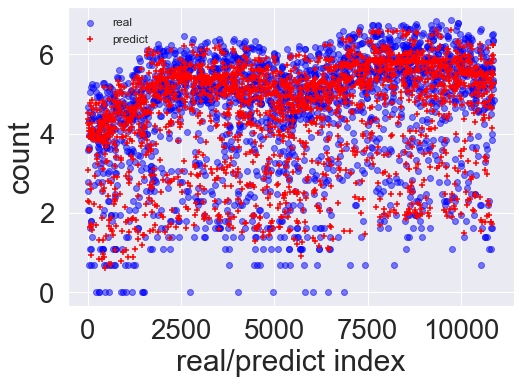

In [763]:
# 참고로 y값은 로그 취했기 때문에 실제 제출할때는 원래 값으로 변환(np.exp) 필요함. (다만, 그래프 그리는 용도면 log 취한 값으로 비교해도 상관없음)
plt.scatter(y_test.index, y_test, alpha=0.5, color='blue', marker='o', label="real")
plt.scatter(y_test.index, gb_y_pred, color='red', marker='+', label="predict")
plt.xlabel("real/predict index")
plt.ylabel("count")
plt.legend(loc='upper left', fontsize=12)

plt.show()

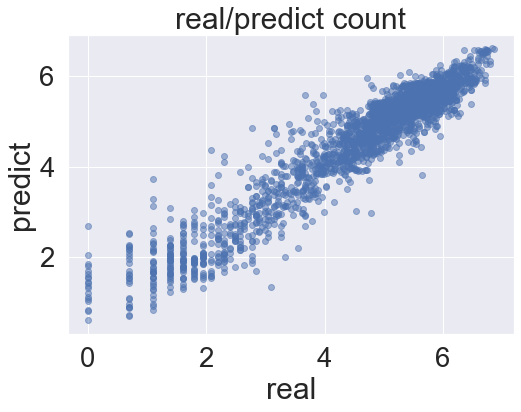

In [764]:
# x축을 실측, y축을 예측으로 했기 때문에 선형관계가 되어야 예측의 정확도가 높음
plt.scatter(y_test, gb_y_pred, alpha=0.5)
plt.xlabel("real")
plt.ylabel("predict")
plt.title("real/predict count")
plt.show()

#### 중요 features 확인

hour_4           0.184695
hour_3           0.143385
hour_2           0.111735
temp             0.093325
hour_5           0.089591
humidity         0.066541
hour_1           0.063828
day_of_week_6    0.039992
day_of_week_5    0.031835
hour_0           0.028602
season_1         0.015430
hour_8           0.015019
year_2011        0.014981
hour_6           0.014838
hour_17          0.014501
year_2012        0.013190
hour_18          0.012614
hour_23          0.007838
season_4         0.007673
weather_3        0.006427
dtype: float64


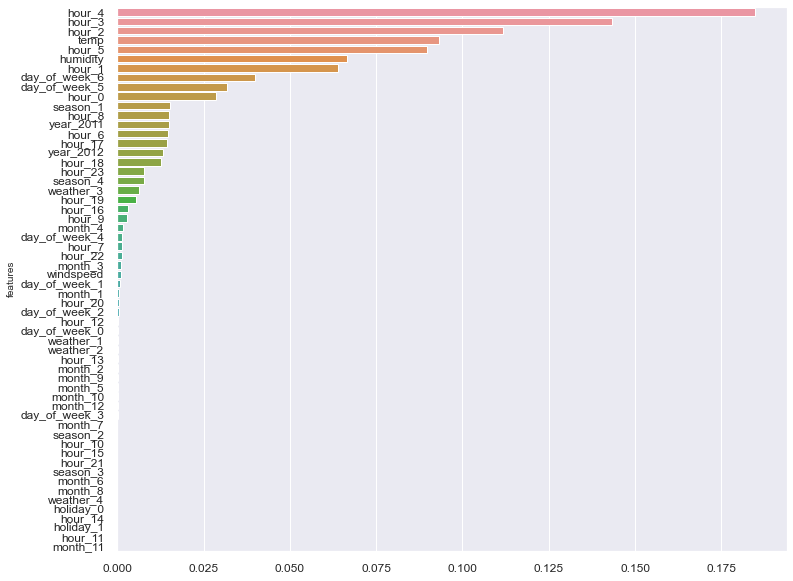

In [765]:
gb_features = gb_regressor.feature_importances_
gb_features_s = pd.Series(gb_features, index = x_train.columns)
gb_features_s = gb_features_s.sort_values(ascending=False)
print(gb_features_s[:20])

plt.figure(figsize=(12,10))
plt.ylabel('features', fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.barplot(x=gb_features_s, y=gb_features_s.index)
plt.show()

#### 기본 값으로 모델 훈련

In [766]:
# rf = RandomForestRegressor(random_state=42, n_estimators=2000, min_samples_split=0.1, max_depth=5)
bgr_default_regressor = GradientBoostingRegressor(random_state=42, n_estimators=2000)
# rf = RandomForestRegressor(random_state=42, n_estimators=2000)
bgr_default_regressor.fit(x_train, y_train)
# ensemble 모델의 socre는 Accuracy를 계산하는 함수로 x_test, y_test가 들어간다면, accuracy_score에서는 y_pred, y_test로 평가를 수행함.
bgr_default_train_score = bgr_default_regressor.score(x_train, y_train)
bgr_default_test_score = bgr_default_regressor.score(x_test, y_test)
print(f"GradientBoostingRegressor train score: {bgr_default_train_score}")
print(f"GradientBoostingRegressor test score: {bgr_default_test_score}")
bgr_default_y_pred = bgr_default_regressor.predict(x_test)
print(y_test.shape, bgr_default_y_pred.shape )
print(f"RMSLE score: {rmsle_score(bgr_default_y_pred, y_test)}")

GradientBoostingRegressor train score: 0.9729924327864572
GradientBoostingRegressor test score: 0.947671491436066
(2175,) (2175,)
RMSLE score: 0.11285274043620254


In [767]:
bgr_default_regressor.get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

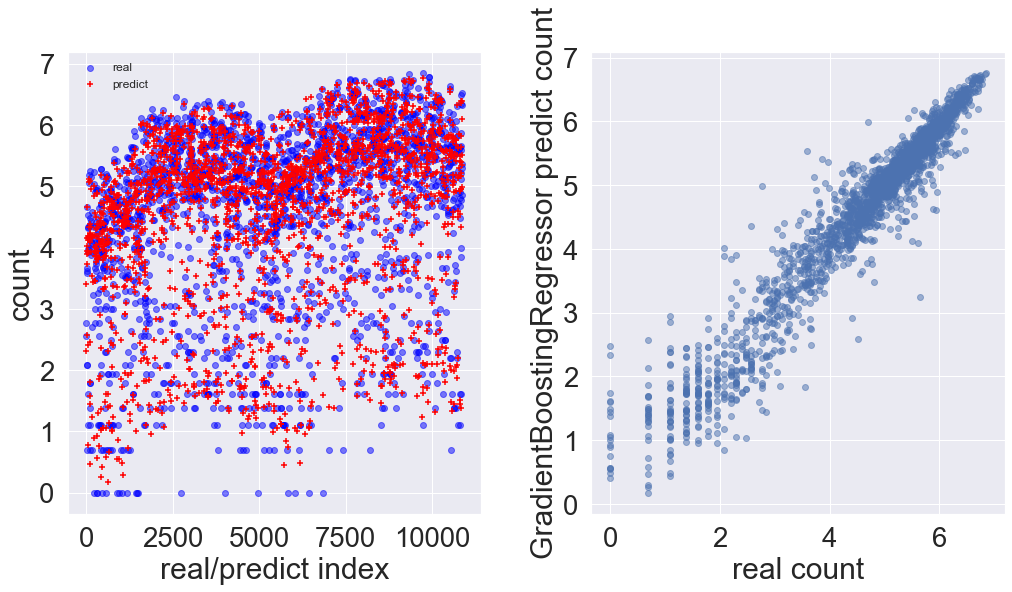

In [772]:
# 참고로 y값은 로그 취했기 때문에 실제 제출할때는 원래 값으로 변환(np.exp) 필요함. (다만, 그래프 그리는 용도면 log 취한 값으로 비교해도 상관없음)
fig, ax = plt.subplots(ncols=2, figsize=(15,8))
fig.tight_layout()

ax[0].scatter(y_test.index, y_test, alpha=0.5, color='blue', marker='o', label="real")
ax[0].scatter(y_test.index, rf_default_y_pred, color='red', marker='+', label="predict")
ax[0].set_xlabel("real/predict index")
ax[0].set_ylabel("count")
ax[0].legend(loc='upper left', fontsize=12)

ax[1].scatter(y_test, rf_default_y_pred, alpha=0.5)
ax[1].set_xlabel("real count")
ax[1].set_ylabel("GradientBoostingRegressor predict count")

plt.show()

### 4) XGBoost

In [294]:
import xgboost as xgb

### 5) KFold 방식의 다중 모델 평가 방식 

In [599]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
models = [RandomForestRegressor(), GradientBoostingRegressor()]
models_nm = ['RandomForestRegressor', 'GradientBoostingRegressor']
socre_result = []
for m in models:
    score = cross_val_score(m, x_train, y_train, cv=kfold, scoring=RMSLE)
    socre_result.append(score.mean())

kfold_result_df = pd.DataFrame({'score': socre_result}, index = models_nm)
kfold_result_df

,score
RandomForestRegressor,0.124457
GradientBoostingRegressor,0.151764


## 제출

test 데이터에 대해서 predict을 수행한 뒤 submission.csv로 파일을 만들어서 제출

In [255]:
print(new_test_df[feature_cols].shape)
new_test_df.tail()

(6493, 51)


,datetime,temp,humidity,windspeed,day,weather_2,weather_3,weather_4,season_2,season_3,...,hour_20,hour_21,hour_22,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
6488,2012-12-31 19:00:00,10.66,60,11.0014,31,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6489,2012-12-31 20:00:00,10.66,60,11.0014,31,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6490,2012-12-31 21:00:00,10.66,60,11.0014,31,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6491,2012-12-31 22:00:00,10.66,56,8.9981,31,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6492,2012-12-31 23:00:00,10.66,65,8.9981,31,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [256]:
sub_df = pd.DataFrame()
sub_df['datetime'] = new_test_df['datetime']
sub_df.tail() 

,datetime
6488,2012-12-31 19:00:00
6489,2012-12-31 20:00:00
6490,2012-12-31 21:00:00
6491,2012-12-31 22:00:00
6492,2012-12-31 23:00:00


In [258]:
y_pred = gb_regressor.predict(new_test_df[feature_cols])

In [259]:
# count에 대해서 log취한 값을 복원함
sub_df['count'] = np.exp(y_pred)

In [260]:
sub_df.tail() 

,datetime,count
6488,2012-12-31 19:00:00,199.468279
6489,2012-12-31 20:00:00,150.007909
6490,2012-12-31 21:00:00,98.123069
6491,2012-12-31 22:00:00,73.571657
6492,2012-12-31 23:00:00,44.489346
